# Evaluation of ranked information retrieval

In [1]:
import numpy as np
import nbimporter
import vectorspace as vec
import probabilisticsearch as prs
from collections import defaultdict
import utilities as utils
import pymongo
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

Importing Jupyter notebook from vectorspace.ipynb
Importing Jupyter notebook from probabilisticsearch.ipynb
Importing Jupyter notebook from utilities.ipynb


In [2]:
class QueryEvaluation(object):
    
    def __init__(self, data_model, vector_model, tokenizer):
        self.data = data_model
        self.vsm = vector_model
        self.tokenizer = tokenizer
        self.relevance = self.data.relevance()
        self.docs = self.vsm.db.distinct('document')
    
    def queryset(self):
        qs = {}
        for query in self.data.readdocs(self.data.queryfile):
            qid, qtext = query['id'], query['text']
            qs[qid] = [token['lemma'] 
                       for token in tokenizer.tokenize(qid, qtext)]
        return qs
    
    def top_k_selection(self, q_id, q_tokens, 
                         min_relevance_judgment=0, percentile=90,
                        idf_filtering_percentile=None
                       ):
        """
        Calculates boolean Precision and Recall by selecting
        a given percentile in the answers set
        """
        if idf_filtering_percentile is not None:
            idf_data = dict([(x, np.log(len(self.docs) / len(y))) 
                             for x, y in self.vsm.idfi.items()])
            idf_filter = np.percentile(list(idf_data.values()), 
                                       idf_filtering_percentile)
            q_tokens = [x for x in q_tokens 
                        if x in idf_data.keys() and idf_data[x] >= idf_filter]
        relevant_docs = self.relevance[
            (self.relevance['query'] == q_id) & 
            (self.relevance['relevance'] >= min_relevance_judgment)].doc.values
        answers = dict(self.vsm.search(q_tokens))
        y_true = np.array([1 if x in relevant_docs else 0 for x in self.docs])
        if len(answers) == 0:
            return y_true, np.zeros(len(self.docs)), np.zeros(len(self.docs)), {}, q_tokens
        threshold = np.percentile(list(answers.values()), percentile)
        y_pred = np.array([1 if (x in answers.keys() and answers[x] >= threshold) 
                           else 0 for x in self.docs])
        scores = np.array([answers[x] if x in answers.keys() 
                           else 0 for x in self.docs])
        return y_true, y_pred, scores, answers, q_tokens
    
    @staticmethod
    def plot_cm(y_true, y_pred, cmap=plt.cm.Blues):
        cm = mtr.confusion_matrix(y_true, y_pred)
        classes = list(unique_labels(y_true, y_pred))
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax

In [3]:
data = utils.Games('ginfo', 'boardgames', 
                   ['"Arkham Horror"', '"World War"', 'political game', 
                    'Monopoly', '"Miskatonic University"',
                    'Monopoly Risk legacy game pandemic'
                   ])
# data = utils.Cranfield('/Users/alfio/Dati/cranfield/cran')

In [4]:
D = data.relevance()

In [18]:
rel_docs = list(D[D['query'] == 2].doc.values)

In [19]:
vsm = vec.VSM('inforet', 'bgg_tokens', field='lemma')
bim = prs.BIM('inforet', 'bgg_tokens', true_doc_ids=rel_docs, field='lemma')
tokenizer = utils.Tokenizer(language=('en', 'english'))

In [20]:
E = QueryEvaluation(data, vsm, tokenizer)
Eb = QueryEvaluation(data, bim, tokenizer)
q_tokens = E.queryset()

In [21]:
q_tokens

{0: ['arkham', 'horror'],
 1: ['world', 'war'],
 2: ['political', 'game'],
 3: ['monopoly'],
 4: ['miskatonic', 'university'],
 5: ['monopoly', 'risk', 'legacy', 'game', 'pandemic']}

In [22]:
query = 2
y_true, y_pred, scores, answers, q = E.top_k_selection(query, q_tokens[query], 
                                   min_relevance_judgment=0, percentile=20,
                                          idf_filtering_percentile=0)
y_true_b, y_pred_b, scores_b, answers_b, q_b = Eb.top_k_selection(query, q_tokens[query], 
                                   min_relevance_judgment=0, percentile=90,
                                          idf_filtering_percentile=0)

In [23]:
print(y_true[:10])
print(y_pred[:10])
print(scores[:10])
print(y_true_b[:10])
print(y_pred_b[:10])
print(scores_b[:10])

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 0 1 1 1 1]
[0.01335197 0.01021104 0.00422032 0.00150803 0.01138233 0.00301591
 0.02238806 0.01121502 0.00442712 0.01351183]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[0.00523834 0.04160797 0.00523834 0.00523834 0.00523834 0.00523834
 0.00523834 0.00523834 0.00523834 0.00523834]


## Results reading

In [24]:
docs = dict([x['id'], x['text']] for x in E.data.readdocs())
print(q, '\n')
for doc, relevance in sorted(answers.items(), key=lambda x: -x[1])[:5]:
    relevance_class = E.relevance[
        (E.relevance['query'] == query) & (E.relevance['doc'] == doc)].relevance.values
    print(doc, relevance, relevance_class)
    print(docs[doc], '\n')

['political', 'game'] 

16261300 0.042038622909027254 [1.05]
Based on the popular mobile game by GungHo, this is a deck-building game with well-known characters from the mobile game.<br/><br/> 

3135100 0.0356958243783826 [0.83333333]
This is a Monopoly game using Santiago&rsquo;s streets, Chile. The game uses pesos with Chilean money pictures instead of dollars.<br/><br/> 

6457500 0.03536553302862452 [0.83333333]
Monopoly game with Major League Baseball teams as the properties and other baseball related themes for the other board spaces.  The game is branded with 'Bank of America'.<br/><br/> 

5767600 0.03189607744679781 [0.53571429]
The famous Monopoly game. In this version you can buy, sell and trade the property of the Belgium city Antwerpen.<br/><br/> 

2179500 0.03146040870609141 [1.05226293]
An expansion in the Dungeon Twister series of games. As all expansion, it can be played as a stand-alone game (if you know the rules from the basic game, available on the game website and y

In [25]:
docs = dict([x['id'], x['text']] for x in Eb.data.readdocs())
print(q, '\n')
for doc, relevance in sorted(answers_b.items(), key=lambda x: -x[1])[:5]:
    relevance_class = Eb.relevance[
        (Eb.relevance['query'] == query) & (Eb.relevance['doc'] == doc)].relevance.values
    print(doc, relevance, relevance_class)
    print(docs[doc], '\n')

['political', 'game'] 

15363500 0.041607971545042956 [1.79525862]
Politics is played on a board (referred to as the political field) consisting of an outer square, and a series of inner squares of various sizes arranged within the outer square, each of them rotated 45 degrees from each other so that their corners bisect the other squares' sides.  These points (24 of them) are referred to as stations.  The two players have different colored pieces.  There are three sizes of game piece; each player has two statesmen (large,) four politicians (medium,) and six voters (small,) for a total of twelve, referred to as that player's phalanx.<br/><br/>The game begins with players taking turns placing any one of their pieces on any one station.  Like Mill, when a player is able to line up three of his pieces in a row, he is then entitled to remove one of his opponent's pieces, but in the case of this game, only voters may be removed in this fashion.  Unlike Mill, pieces in Politics may jump and 

## Classification report
The reported averages include micro average (averaging the total true positives, false negatives and false positives), macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label) and sample average (only for multilabel classification), see <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report">sklearn.metrics.classification_report</a>.

In [26]:
print(mtr.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       403
           1       1.00      0.77      0.87      1218

   micro avg       0.82      0.82      0.82      1621
   macro avg       0.79      0.88      0.80      1621
weighted avg       0.90      0.82      0.84      1621



In [27]:
print(mtr.classification_report(y_true_b, y_pred_b))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       403
           1       1.00      0.96      0.98      1218

   micro avg       0.97      0.97      0.97      1621
   macro avg       0.94      0.98      0.96      1621
weighted avg       0.97      0.97      0.97      1621



## Confusion matrix
Labels is a list of labels to index the matrix. This may be used to reorder or select a subset of labels. If none is given, those that appear at least once in y_true or y_pred are used in sorted order.

In [28]:
cm = mtr.confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
cm_b = mtr.confusion_matrix(y_true_b, y_pred_b)
tn_b, fp_b, fn_b, tp_b = cm_b.ravel()

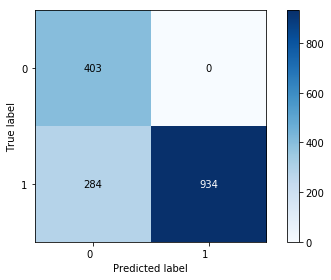

In [29]:
QueryEvaluation.plot_cm(y_true, y_pred)
plt.show()

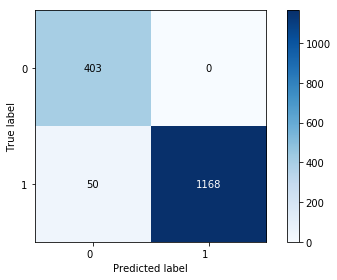

In [30]:
QueryEvaluation.plot_cm(y_true_b, y_pred_b)
plt.show()

### Precision-Recall curve
Gets precision, recall and the thresholds, given the relevance judgments and the system scores.

In [ ]:
precision, recall, thresholds = mtr.precision_recall_curve(y_true, scores)
precision_b, recall_b, thresholds_b = mtr.precision_recall_curve(y_true_b, scores_b)

In [ ]:
print(precision[-5:])
print(recall[-5:])
print(thresholds[-5:])
print(precision_b[-5:])
print(recall_b[-5:])
print(thresholds_b[-5:])

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
ax[0,0].plot(precision, label='Precision VSM')
ax[0,0].plot(recall, label='Recall VSM')
step_th = max([len(thresholds) // 10, 1])
ax[0,0].set_xticks(range(0, len(thresholds), step_th))
ax[0,0].set_xticklabels([round(thresholds[x], 5) 
                       for x in range(0, len(thresholds), step_th)], rotation=90)
ax[0,0].legend()

ax[1,0].plot(precision_b, label='Precision BIM')
ax[1,0].plot(recall_b, label='Recall BIM')
step_th_b = max([len(thresholds_b) // 10, 1])
ax[1,0].set_xticks(range(0, len(thresholds_b), step_th_b))
ax[1,0].set_xticklabels([round(thresholds_b[x], 5) 
                       for x in range(0, len(thresholds_b), step_th_b)], rotation=90)
ax[1,0].legend()


fp = np.flip(precision)
step_r = max([len(recall) // 10, 1])
ax[0,1].plot(fp, label='Precision VSM')
ax[0,1].set_xticks(range(0, len(recall), step_r))
ax[0,1].set_xticklabels([round(recall[0-x-1], 2) 
                       for x in range(0, len(recall), step_r)], rotation=90)
ax[0,1].legend()
ax[0,1].set_xlabel('Recall')
ax[0,1].set_ylabel('Precision')

fp_b = np.flip(precision_b)
step_r_b = max([len(recall_b) // 10, 1])
ax[1,1].plot(fp_b, label='Precision BIM')
ax[1,1].set_xticks(range(0, len(recall_b), step_r_b))
ax[1,1].set_xticklabels([round(recall_b[0-x-1], 2) 
                       for x in range(0, len(recall_b), step_r_b)], rotation=90)
ax[1,1].legend()
ax[1,1].set_xlabel('Recall')
ax[1,1].set_ylabel('Precision')


interpolated_p = [max(fp[i:]) for i, x in enumerate(fp)]
ax[0,2].plot(interpolated_p, label='Precision VSM')
ax[0,2].set_xticks(range(0, len(recall), step_r))
ax[0,2].set_xticklabels([round(recall[0-x-1], 2) 
                       for x in range(0, len(recall), step_r)], rotation=90)
ax[0,2].legend()
ax[0,2].set_xlabel('Recall')
ax[0,2].set_ylabel('Precision')

interpolated_p_b = [max(fp_b[i:]) for i, x in enumerate(fp_b)]
ax[1,2].plot(interpolated_p_b, label='Precision BIM')
ax[1,2].set_xticks(range(0, len(recall_b), step_r_b))
ax[1,2].set_xticklabels([round(recall_b[0-x-1], 2) 
                       for x in range(0, len(recall_b), step_r_b)], rotation=90)
ax[1,2].legend()
ax[1,2].set_xlabel('Recall')
ax[1,2].set_ylabel('Precision')

plt.tight_layout()
plt.show()

### ROC curve
Compute Receiver operating characteristic (ROC).
We want to study the error of the system by combining:
- TPR = TP / (TP + FN)
- FPR = FP / (FP + TN)

In [ ]:
fpr, tpr, _ = mtr.roc_curve(y_true, scores)
fpr_b, tpr_b, _ = mtr.roc_curve(y_true_b, scores_b)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve VSM')
plt.plot(fpr_b, tpr_b, label='ROC curve BIM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()